In [1]:
import os
os.chdir("/mnt/iusers01/jw01/mdefscs4/ra_challenge/hestia/Hestia_imeche_vision_challenge/NN_recognition_train")

In [9]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as k
import glob
from PIL import Image
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataset.train_generator import retrieve_tf_dataset, train_generator
from model.mobile_net_GAP import retrieve_mobilenet_model, custom_crossentropy, custom_mse

In [77]:
model = k.models.load_model("weights/step1_new_model_mobilenet.tf", custom_objects = {"custom_crossentropy": custom_crossentropy, "custom_mse": custom_mse})

In [78]:
tf_data = retrieve_tf_dataset()

In [79]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('test_tflite_conversion.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa6ichatm/assets


INFO:tensorflow:Assets written to: /tmp/tmpa6ichatm/assets


In [80]:
def rep_dataset():
    generator = train_generator()
    for i in range(1000):
        image = next(generator)[0]
        image = tf.expand_dims(image, 0)
        image = tf.image.resize(image, (224, 224))
        yield [image]

In [81]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = rep_dataset
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('test_tflite_conversion.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8egqw527/assets


INFO:tensorflow:Assets written to: /tmp/tmp8egqw527/assets


In [82]:
interpreter = tf.lite.Interpreter('test_tflite_conversion.tflite')
interpreter.allocate_tensors()

In [83]:
def set_input_tensor(interpreter, input):
    input_details = interpreter.get_input_details()[0]
    tensor_index = input_details['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    # Inputs for the TFLite model must be uint8, so we quantize our input data.
    # NOTE: This step is necessary only because we're receiving input data from
    # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
    # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
    #   input_tensor[:, :] = input
    scale, zero_point = input_details['quantization']
    input_tensor[:, :] = np.uint8(input / scale + zero_point)

In [84]:
def classify_image(interpreter, input):
    set_input_tensor(interpreter, input)
    interpreter.invoke()
    output_details_0 = interpreter.get_output_details()[0]
    output_details_1 = interpreter.get_output_details()[1]
    output_0 = interpreter.get_tensor(output_details_0['index'])
    output_1 = interpreter.get_tensor(output_details_1['index'])
    # Outputs from the TFLite model are uint8, so we dequantize the results:
    scale, zero_point = output_details_0['quantization']
    output_0 = scale * (output_0 - zero_point)
    scale, zero_point = output_details_1['quantization']
    output_1 = scale * (output_1 - zero_point)
    return output_0, output_1

In [85]:
tf_gen = train_generator()

In [86]:
X,Y = next(tf_gen)

In [87]:
X = tf.expand_dims(X, 0)
X = tf.image.resize(X, (224, 224))

In [88]:
classify_image(interpreter, X)

(array([[0.43744546, 0.40692601, 0.13225095, 0.13225095]]), array([[0.]]))

In [89]:
Y

(0, array([nan, nan, nan, nan]))

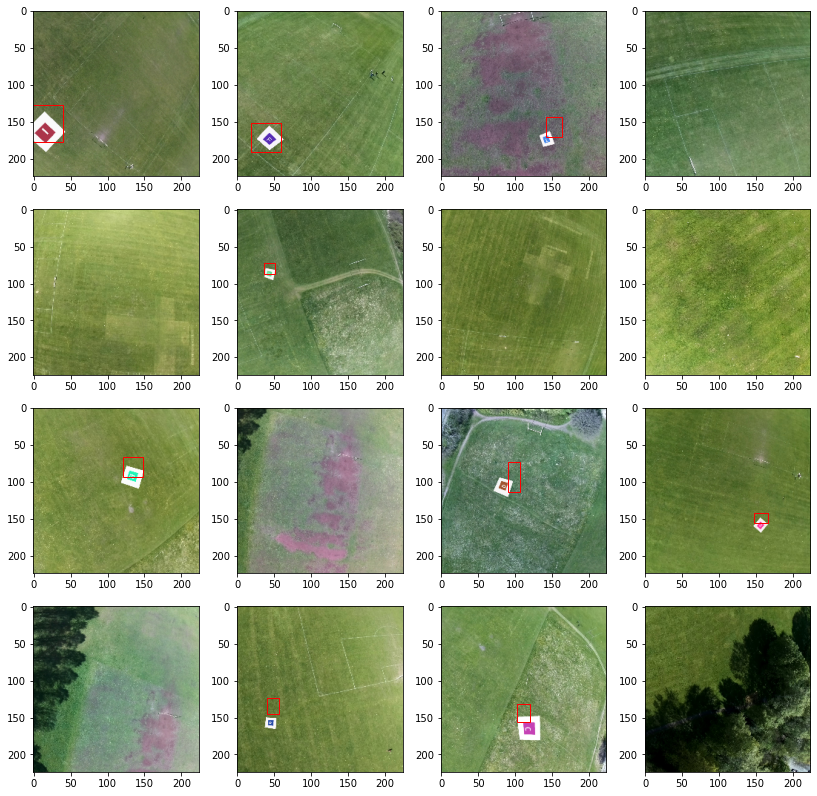

In [91]:
fig, axes  = plt.subplots(4,4, figsize = (14,14))
for i, ax in enumerate(axes.flat):
    X,Y = next(tf_gen)
    X = tf.expand_dims(X, 0)
    X = tf.image.resize(X, (224, 224))
    # Display the image
    ax.imshow(X.numpy().reshape(224,224,3)/255)
        
    res = classify_image(interpreter, X)
    
    X0 = res[0][0][0] - res[0][0][2]/2
    Y0 = res[0][0][1] - res[0][0][3]/2
    # Create a Rectangle patch
    if res[1][0] > 0.5:
        rect = patches.Rectangle((X0*224, Y0*224), res[0][0][2]*224, res[0][0][3]*224, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

In [ ]:


def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))